In [50]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [51]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def one_repeater_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
    """ calculates the performance of parallel scheme with one repeater
    inputs:
        L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        Nmax: ensemble size for averaging
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    # N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    # N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    N1 = F_geo(np.random.rand(Nmax),p1)
    N2 = F_geo(np.random.rand(Nmax),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
    t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
    t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
    indsL = np.argwhere( t1L <= τ_cut )[:,0]
    indsR = np.argwhere( t1R <= τ_cut )[:,0]
    succ_inds = np.intersect1d(indsL,indsR)
    T_succ = np.sum(Ts[succ_inds]+ τ1) 
    fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
    # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
    # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
    # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
    # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
    L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
    R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
    # print(list(np.array(fail_inds)[L_runs]))
    left_mem_on_idx = list(np.array(fail_inds)[L_runs])
    right_mem_on_idx = list(np.array(fail_inds)[R_runs])
    T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
    T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
    T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)

    mean_succ =  T_succ/len(succ_inds)
    mean_fail = T_fail/len(fail_inds)
    # print("Mean succ time: ", T_succ/len(succ_inds))
    # print("Mean fail time: ", T_fail/len(fail_inds))
    # print("success prob", len(succ_inds)/Nmax)
    # print("fail prob", len(fail_inds)/Nmax)

    raw_rate = len(succ_inds)/(T_succ+T_fail)
    t_idle_qkd = t1L + t1R
    f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
    N_links = 2
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
    tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
    t_idle_bell = tA + tB + t1L + t1R
    mean_sender = tA[succ_inds].mean()
    mean_receiver = tB[succ_inds].mean()
    f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
    # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
    # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
    return raw_rate, skr, f_e2e_bell, mean_succ, mean_fail#, mean_sender, mean_receiver
    # return raw_rate, skr, f_e2e_bell 

def T_parallel_no_cutoff(τ_coh, mu_link, F_link, links, cct= True, Nmax=10000):
    """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
        cct: bool flag to turn on/off classical comm.
        Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)

    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    raw_rate = 1/T_tot
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    return raw_rate, skr, F_e2e


In [52]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_parallel_cutoff(τ_cut, τ_coh, mu_link, F_link,links, cct= True, Nmax=100000):
    """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
        cct: bool flag to turn on/off classical comm.
        Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)

    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    for i in range(N_links):
        Ns[i,:] = F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))

    Tswap = np.zeros((N_links-1,Nmax))
    Tswap_cc = np.zeros((N_links-1,Nmax))
    tL = np.zeros((N_links-1,Nmax))
    tR = np.zeros((N_links-1,Nmax))
    # Ts = np.zeros((N_links-1,Nmax))
    # Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    # Tswap[0,:] = np.max(np.concatenate((2*Ns[1,:],2*Ns[0,:]-τs[0]),axis=0),axis=0)#+ 2*τs[1]
    for i in range(N_links-1):
        # Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
        # mat_cat = np.stack((2*Ns[i+1,:]*τs[i+1],(2*Ns[i,:]-1)*τs[i]),axis=0)
        # print(mat_cat.shape)
        Tswap[i,:] = np.max(np.stack((2*Ns[i+1,:]*τs[i+1],(2*Ns[i,:]-1)*τs[i]),axis=0), axis=0)
        # Tswap[i,:] = np.max(np.concatenate((2*Ns[i+1,:]*τs[i+1],(2*Ns[i,:]-1)*τs[i]),axis=0),axis=0)
        tL[i,:] = Tswap[i,:]- (2*Ns[i,:]-1)*τs[i]
        tR[i,:] = Tswap[i,:]- 2*(Ns[i+1,:]-1)*τs[i+1]
        Tswap_cc[i,:] = Tswap[i,:] + np.sum(τs[:(i+1)])
    # indsL = np.argwhere( tL <= τ_cut )#[:,0]
    # indsR = np.argwhere( t1R <= τ_cut )[:,0]
    indsL = np.argwhere(np.sum( tL <= τ_cut , axis = 0)== N_links-1 )[:,0]
    indsR = np.argwhere(np.sum( tR <= τ_cut , axis = 0)== N_links-1 )[:,0]
    succ_inds = np.intersect1d(indsL,indsR)
    T_succ = np.sum(np.max(Tswap_cc[:,succ_inds],axis=0))           
    mean_succ =  T_succ/len(succ_inds)
    # return mean_succ
    fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
    T_fail = 0
    for i_r in fail_inds:
        indsL = np.argwhere( tL[:,i_r] > τ_cut )[:,0]
        indsR = np.argwhere( tR[:,i_r] > τ_cut )[:,0]
        tsL = []
        for i_L in indsL:
            tsL.append((2*Ns[i_L,i_r]-1)*τs[i_L] + np.sum(τs[:(i_L+1)]))
        tsR = []
        for i_R in indsR:
            tsR.append(2*(Ns[i_R+1,i_r]-1)*τs[i_R+1]+ np.sum(τs[:(i_R+1)]))
        
        T_fail += min(tsL + tsR)+ τ_cut
        
    raw_rate = len(succ_inds)/(T_succ+T_fail)
    mean_fail= 0
    if len(fail_inds)> 0:
        mean_fail=  T_fail/len(fail_inds)

    # return raw_rate
# print(indsL,indsR)

    # f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    # if cct: # inclduing classical comm. 
    #     Tsw = np.zeros((N_links-1,Nmax))
    #     Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
    #     for i in range(1,N_links-1):
    #         Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
    #     T_tot = np.mean(np.max(Tsw,axis=0))           
    #     Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
    #     Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
    #     f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    # else:
    #     T_tot = np.mean(np.max(Ns,axis=0))
    #     Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
    #     Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
    #     f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    Ts_A = np.max(Tswap_cc[:,succ_inds],axis=0)- (Ns[0,succ_inds]-1)* τs[0] 
    Ts_B = np.max(Tswap_cc[:,succ_inds],axis=0)- (Ns[-1,succ_inds]-1)* τs[-1] 
    f_memory_bell = np.mean(np.exp(-(np.sum(tL[:,succ_inds]+tR[:,succ_inds],axis=0)+Ts_A+Ts_B)/τ_coh))

    f_memory_qkd = np.mean(np.exp(-np.sum(tL[:,succ_inds]+tR[:,succ_inds],axis=0)/τ_coh))
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    return raw_rate, skr, F_e2e, mean_succ, mean_fail


In [63]:
n = 2 # number of segments (i.e., no. of repeaters -1 )
τ_coh = 1e-3 # coherence time [sec]
Le2e = 100 # e2e distance [km]
τ_cut_list = np.logspace(0,4,21)*Le2e/(2*c) # cutoff [sec]
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

raw_rate_par = np.zeros(len(τ_cut_list))
skr_par = np.zeros(len(τ_cut_list))
Fe2e_par = np.zeros(len(τ_cut_list))
mean_succ = np.zeros(len(τ_cut_list))
mean_fail = np.zeros(len(τ_cut_list))
raw_rate_one_par = np.zeros(len(τ_cut_list))
skr_one_par = np.zeros(len(τ_cut_list))
Fe2e_one_par = np.zeros(len(τ_cut_list))
mean_succ_one_par  = np.zeros(len(τ_cut_list))
mean_fail_one_par  = np.zeros(len(τ_cut_list))

for i_t, τ_cut in enumerate(τ_cut_list):
    Ls = [Le2e/n]*n
    # L1 = 0.3*Le2e
    # L2 = Le2e-L1
    # Ls = [L1, L2]
    Nm = 1e6
    raw_rate_par[i_t], skr_par[i_t], Fe2e_par[i_t],mean_succ[i_t], mean_fail[i_t] = T_parallel_cutoff(τ_cut, τ_coh, mu_link, F_link,Ls, cct= True, Nmax=Nm)
    # raw_rate_par[i_t] = T_parallel_cutoff(τ_cut, τ_coh, mu_link, F_link,Ls, cct= True, Nmax=1e4)
    # raw_rate_one_par[i_t], skr_one_par[i_t], Fe2e_one_par[i_t], mean_succ_one_par[i_t], mean_fail_one_par[i_t] = one_repeater_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=Nm)


/tmp/ipykernel_2021808/1833851934.py:53: RuntimeWarning: invalid value encountered in scalar divide
  mean_succ =  T_succ/len(succ_inds)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


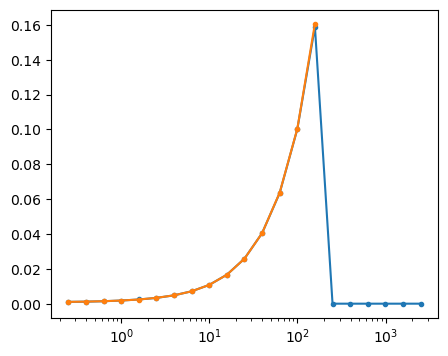

In [46]:
plt.figure(figsize=(5,4))
# plt.plot(τ_cut_list*1e3,mean_succ,"-",color="C0",label="par")
plt.plot(τ_cut_list*1e3,mean_fail,".-",color="C0",label="par")

# plt.plot(τ_cut_list*1e3,mean_succ_one_par,"-",color="C1",label="one")
plt.plot(τ_cut_list*1e3,mean_fail_one_par,".-",color="C1",label="one")
plt.xscale('log')
# plt.yscale('log')


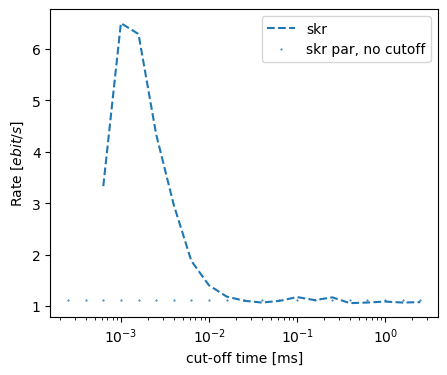

In [60]:
plt.figure(figsize=(5,4))
# plt.plot(τ_cut_list*1e3,raw_rate_par,"-",color="C0",label="raw rate par")
plt.plot(τ_cut_list,skr_par,"--",color="C0",label="skr")

# plt.plot(τ_cut_list*1e3,raw_rate_one_par,"-",color="C1",label="raw rate seq")
# plt.plot(τ_cut_list,skr_one_par,"--",color="C1",label="skr")

# # for reference:
raw_rate_par_no_cut, skr_par_no_cut, _  = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls, cct= True, Nmax=1e6)
# # raw_rate_seq_no_cut, skr_seq_no_cut, _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, [Le2e/2,Le2e/2])
# plt.plot(τ_cut_list*1e3,raw_rate_par_no_cut+0*τ_cut_list , "-." ,color="C0",label="raw rate par, no cutoff")
# # plt.plot(τ_cut_list*1e3,raw_rate_seq_no_cut+0*τ_cut_list , "-." ,color="C1",label="raw rate seq, no cutoff")
plt.plot(τ_cut_list,skr_par_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C0",label="skr par, no cutoff")
# # plt.plot(τ_cut_list*1e3,skr_seq_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C1",label="skr seq, no cutoff")

# raw_rate_par_one_rep_no_cut, skr_par_one_rep_no_cut, _  = one_repeater_no_cutoff(τ_coh,mu_link, F_link, Le2e/2, Le2e/2,Nmax=1e6)
# # plt.plot(τ_cut_list*1e3,raw_rate_par_one_rep_no_cut+0*τ_cut_list , "x" ,color="C1",label="raw rate par, 1 rep, no c")
# plt.plot(τ_cut_list,skr_par_one_rep_no_cut+0*τ_cut_list , "x", markersize=3 ,color="C1",label="skr par,1rep, no c")

# plt.yscale('log')
plt.xscale('log')
plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()


In [62]:
skr_par

array([       nan,        nan, 3.33179198, 6.505206  , 6.29235716,
       4.34388914, 2.96876937, 1.87551822, 1.40250647, 1.18281057,
       1.1013809 , 1.0655923 , 1.09794574, 1.1730615 , 1.11329585,
       1.16706344, 1.05468408, 1.06649733, 1.08503186, 1.06538205,
       1.07435585])